In [ ]:
import pandas as pd

# Get Data

In [ ]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
df = pd.read_csv(url,index_col=0)
df.head()

,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,...,1/21/23,1/22/23,1/23/23,1/24/23,1/25/23,1/26/23,1/27/23,1/28/23,1/29/23,1/30/23
UID,,,,,,,,,,,,,,,,,,,,,
84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",...,230,230,230,230,230,230,230,230,230,230
84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",...,722,722,722,722,723,723,723,723,723,723
84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",...,103,103,103,103,103,103,103,103,103,103
84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",...,109,109,109,109,109,109,109,109,109,109
84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",...,261,261,261,261,261,261,261,261,261,261


In [ ]:
daily_death = pd.DataFrame(df[df.columns[11:]].sum())
daily_death.columns=['cum_death']
daily_death['new_death']=daily_death['cum_death'].diff().fillna(daily_death['cum_death'])

In [ ]:
df_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv",index_col=0)
df_cases.head()

,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,...,11/30/22,12/1/22,12/2/22,12/3/22,12/4/22,12/5/22,12/6/22,12/7/22,12/8/22,12/9/22
UID,,,,,,,,,,,,,,,,,,,,,
84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",...,18680,18680,18680,18680,18680,18680,18680,18752,18752,18752
84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",...,66730,66730,66730,66730,66730,66730,66730,66951,66951,66951
84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",...,6980,6980,6980,6980,6980,6980,6980,6989,6989,6989
84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",...,7637,7637,7637,7637,7637,7637,7637,7653,7653,7653
84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",...,17500,17500,17500,17500,17500,17500,17500,17559,17559,17559


In [ ]:
daily_cases = pd.DataFrame(df_cases[df_cases.columns[11:]].sum())
daily_cases.columns=['cum_cases']
daily_cases['new_cases']=daily_cases['cum_cases'].diff().fillna(daily_cases['cum_cases'])
daily_cases.head(10)

,cum_cases,new_cases
1/23/20,1,1.0
1/24/20,2,1.0
1/25/20,2,0.0
1/26/20,5,3.0
1/27/20,5,0.0
1/28/20,5,0.0
1/29/20,6,1.0
1/30/20,6,0.0
1/31/20,8,2.0
2/1/20,8,0.0


# Build SIRD model

In [ ]:
import numpy as np
from scipy.optimize import minimize, curve_fit
from scipy import integrate, optimize
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [ ]:
def model(params, time_step):
  beta, gamma, S0, I0, d = params
  N = S0 + I0
  S = [S0]
  I = [I0]
  R = [0]
  D = [0]
  dS =[]
  dI = []
  dR = []
  dD = []
  for t in range(0,time_step):
    dS.append(-beta*I[t]*S[t]/N)
    dI.append(beta*I[t]*S[t]/N- gamma*I[t] - d*I[t])
    dR.append(gamma*I[t])
    dD.append(d*I[t])
    S.append(S[t] + dS[t])
    I.append(I[t] + dI[t])
    R.append(R[t] + dR[t])
    D.append(D[t] + dD[t])
  return I, D

def error(params, time_step, actual_I, actual_D):
  I_pred, D_pred = model(params, time_step)
  beta, gamma, S0, I0, d = params
  I_error = 0
  D_error = 0
  for t in range(0,time_step):
    I_error+=abs(I_pred[t]-actual_I[t])
    D_error+=abs(D_pred[t]-actual_D[t])
  total_error = I_error + D_error
  return total_error








In [ ]:
actual_cum_cases = daily_cases["cum_cases"]
actual_cum_death = daily_death["cum_death"]
actual_cum_case = [i/10000000 for i in actual_cum_cases.values.tolist()]
actual_cum_death = [i/10000000 for i in actual_cum_death.values.tolist()]


### Assign an initial value and fit the parameter

In [ ]:
initial_value = [8.63e-1,1.53e-4,18.3,6.78e-5,8.6e-1]
bnds = [(0, 1), (0, 1), (9, 50), (0, 1), (0, 1)]
res = minimize(error,initial_value, args = (1028, actual_cum_cases, actual_cum_death), bounds = bnds, tol=1e-7, method = 'Nelder-Mead', options={'maxiter': 5000})

In [ ]:
print(res)

 final_simplex: (array([[8.63201345e-01, 2.48787398e-04, 1.26890726e+01, 6.77213074e-05,
        8.59425852e-01],
       [8.63201345e-01, 2.48787396e-04, 1.26890726e+01, 6.77213074e-05,
        8.59425852e-01],
       [8.63201345e-01, 2.48787397e-04, 1.26890726e+01, 6.77213073e-05,
        8.59425852e-01],
       [8.63201345e-01, 2.48787395e-04, 1.26890727e+01, 6.77213075e-05,
        8.59425852e-01],
       [8.63201345e-01, 2.48787397e-04, 1.26890726e+01, 6.77213076e-05,
        8.59425852e-01],
       [8.63201345e-01, 2.48787398e-04, 1.26890726e+01, 6.77213074e-05,
        8.59425852e-01]]), array([4.22762574e+10, 4.22762574e+10, 4.22762574e+10, 4.22762574e+10,
       4.22762574e+10, 4.22762574e+10]))
           fun: 42276257373.543175
       message: 'Optimization terminated successfully.'
          nfev: 361
           nit: 157
        status: 0
       success: True
             x: array([8.63201345e-01, 2.48787398e-04, 1.26890726e+01, 6.77213074e-05,
       8.59425852e-01])


### Use grid search to find the best initial param

In [ ]:
from scipy.optimize import brute

In [ ]:
grid = ((8.63e-1,8.63e-1),(1.53e-4,1.53e-4),slice(1,40, 0.1),(6.78e-5, 6.78e-5),(0.86,0.86))
resbrute = brute(error, grid, args = (1028, actual_cum_cases, actual_cum_death), Ns = 1,full_output=True, disp=True, finish=None)
print("Best coeffs: {}".format(resbrute[0]))
print("Score with best coeffs: {}".format(resbrute[1]))
print("Grid: {}".format(resbrute[2].tolist()))
print("Scores for grid: {}".format(resbrute[3].tolist()))

Best coeffs: [8.63e-01 1.53e-04 1.83e+01 6.78e-05 8.60e-01]
Score with best coeffs: 42276257374.381165
Grid: [[[[[[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863]], [[0.863

### Get Predictions

In [ ]:
params = res.x
#params = np.array([0.022,0.00165,33,1e-7,7.5e-6])


In [ ]:
# predictions
I, D = model(params, 1450)
D = pd.DataFrame(D)
D.columns = ['cum_death']
D['new_death']=D['cum_death'].diff().fillna(D['cum_death'])
new_death = [i*10000000 for i in D['new_death']]
print(new_death[1018:])

[422.90521110488476, 421.29197393270255, 419.6836837216944, 418.08033540688405, 416.48192383322845, 414.88844375742184, 413.29988984761815, 411.7162566853738, 410.13753876634195, 408.56373050054964, 406.994826214202, 405.43082015037646, 403.8717064697162, 402.3174792514017, 400.7681324941226, 399.22366011718725, 397.6840559609396, 396.14931378828544, 394.61942728497013, 393.0943900608275, 391.5741956507512, 390.05883751538903, 388.54830904169745, 387.04260354446853, 385.5417142670237, 384.0456343814913, 382.55435699033336, 381.0678751270391, 379.5861817569579, 378.10926977771555, 376.6371320207407, 375.16976125168134, 373.7071501713762, 372.24929141640996, 370.79617756050067, 369.34780111450016, 367.90415452819803, 366.46523019004394, 365.0310204288132, 363.601517513884, 362.17671365634806, 360.75660100970407, 359.3411716702744, 357.93041767873126, 356.52433101995837, 355.1229036245773, 353.7261273695025, 352.3339940780801, 350.94649552203094, 349.5636234210342, 348.1853694442538, 346.

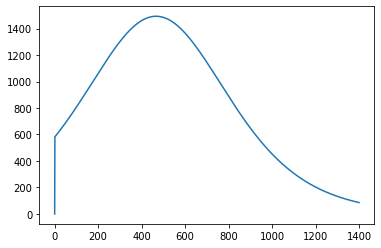

In [ ]:
plt.plot(new_death)


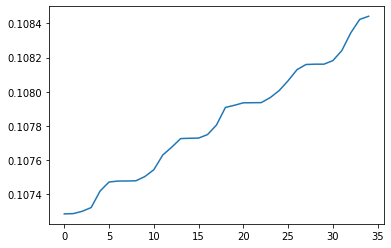

In [ ]:
plt.plot(actual_cum_death[1018:])


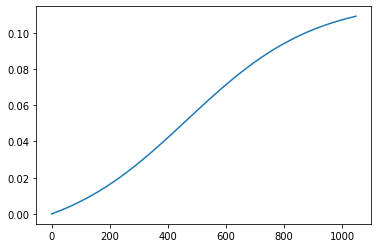

In [ ]:
plt.plot(D['cum_death'])

In [ ]:
D.to_csv('SIRD_death.csv')

In [ ]:
daily_death.to_csv("actual death.csv")

In [ ]:
beta, gamma, S0, I0, d = params
beta * S0/gamma

44026.44433003097